In [1]:
import torch
import sys
import os
import pandas as pd
from scipy import misc
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import glob
import imageio
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
LS = 100 #Latent Space Size


#Archtecture of network
KS = [4,6,6,2,2,2]
ST = [1,2,2,2,2,2]

KS = [4,4,4,4,5,1]
ST = [1,2,1,2,1,1]



In [3]:
datadir = "./images/"


In [ ]:
class XrayDataset(Dataset):

    def __init__(self, datadir, transform=None, nrows=None):

        self.datadir = datadir
        self.transform = transform
        self.ImgFiles = [f.split('/')[-1] for f in glob.glob(datadir+"*.png")]

    def __len__(self):
        return len(self.ImgFiles)

    def __getitem__(self, idx):
        im = imageio.imread(os.path.join(self.datadir, self.ImgFiles[idx]))
        
        #Add color chanel
        im = im[:,:,None]
        # Tranform
        if self.transform:
            im = self.transform(im)
        return im
class Iterator:
    """
    iterator over dataloader which automatically resets when all samples have been seen
    """
    def __init__(self, dataloader):
        self.dataloader = dataloader
        self.cpt = 0
        self.len = len(self.dataloader)
        self.iterator = iter(self.dataloader)

    def next(self):
        if self.cpt == self.len:
            self.cpt = 0
            self.iterator = iter(self.dataloader)
        self.cpt += 1
        return self.iterator.next()

In [ ]:
# Transformations
inputsize = [224, 224]
inputsize = [32,32]
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(inputsize),
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x.repeat(3, 1, 1))
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize dataloader
dataset = XrayDataset(datadir, transform=data_transforms)
dataloader = DataLoader(dataset, shuffle=True, batch_size=12)

print(len(dataset))

501


I=0 K=4 ST=1 Size=4
I=1 K=4 ST=2 Size=10
I=2 K=4 ST=1 Size=13
I=3 K=4 ST=2 Size=28
I=4 K=5 ST=1 Size=32
I=5 K=1 ST=1 Size=32
(32, 32)


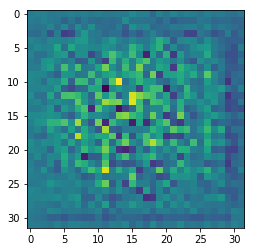

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
# Generator Code

class Generator(nn.Module):
    def __init__(self, latent_size=32,output_shape=224,nc=1,KS= [4,221],ST = [1,1]):
        
        self.latent_size = latent_size
        self.output_shape = output_shape
        self.nc = nc
        
        
        super(Generator, self).__init__()
        
        
        #Build ConvTranspose layer
        self.main = torch.nn.Sequential()
        lastdepth = self.latent_size
        OldDim = 1
        for i in range(len(KS)):
            kernel_size = KS[i]
            stride = ST[i]
            padding = 0
            output_pading = 0
            
            nnc = 8*np.power(2,(len(KS)-i))
            if i == len(KS)-1:
                nnc = 1
            self.main.add_module("ConvT_"+str(i), torch.nn.ConvTranspose2d(lastdepth,nnc,kernel_size,stride,padding,output_pading,bias=False))
            if i != len(KS) - 1:
                self.main.add_module("BN_"+str(i), torch.nn.BatchNorm2d(nnc))
                self.main.add_module("Relu_"+str(i), torch.nn.ReLU(True))
            
            OldDim = (OldDim-1)*stride+kernel_size - 2*padding + output_pading
            lastdepth = nnc
            print("I=%d K=%d ST=%d Size=%d" % (i,kernel_size,stride,OldDim))
            
            
        self.main.add_module("Tanh",nn.Tanh())
       

    def forward(self, input):
        return self.main(input)

GenX = Generator(latent_size=LS,KS=KS,ST=ST)
fkim = GenX(torch.rand(1,LS,1,1)).detach().numpy()[0][0]
print(fkim.shape)
plt.imshow(fkim)
plt.show()

In [ ]:
#torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)

class Discriminator(nn.Module):
    def __init__(self,KS= [4,221],ST = [1,1]):
        super(Discriminator, self).__init__()
        
        
        #Build ConvTranspose layer
        self.main = torch.nn.Sequential()
        
        
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0
        
        self.main = torch.nn.Sequential()
        lastdepth = 1
        nnc = 1
        for i in range(len(KS)):
            
            kernel_size = KS[i]
            stride = ST[i]
            padding = 0
            output_pading = 0
            nnc = 8*np.power(2,i)
            if i == len(KS) -1:
                nnc = 1
            self.main.add_module("ConvT_"+str(i), 
                                 torch.nn.Conv2d(in_channels=lastdepth,out_channels=nnc,
                                                 kernel_size=kernel_size,stride=stride,bias=False))
           
            if i != len(KS) - 1:
                self.main.add_module("BN_"+str(i), torch.nn.BatchNorm2d(nnc))
                self.main.add_module("LRelu_"+str(i), torch.nn.LeakyReLU(0.2, inplace=True))
            
            lastdepth = nnc
            
        self.main.add_module("Sigmoid",nn.Sigmoid())
       

    def forward(self, input):
        return self.main(input)



In [ ]:
import torch.optim as optim





DisX = Discriminator(KS=KS[::-1],ST=ST[::-1])
GenX = Generator(latent_size=LS,KS=KS,ST=ST)

if torch.cuda.is_available():
    DisX = Discriminator(KS=KS[::-1],ST=ST[::-1]).cuda()
    GenX = Generator(latent_size=LS,KS=KS,ST=ST).cuda()
    
print(GenX)
print(DisX)

I=0 K=4 ST=1 Size=4
I=1 K=4 ST=2 Size=10
I=2 K=4 ST=1 Size=13
I=3 K=4 ST=2 Size=28
I=4 K=5 ST=1 Size=32
I=5 K=1 ST=1 Size=32
Generator(
  (main): Sequential(
    (ConvT_0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (BN_0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Relu_0): ReLU(inplace)
    (ConvT_1): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (BN_1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Relu_1): ReLU(inplace)
    (ConvT_2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (BN_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Relu_2): ReLU(inplace)
    (ConvT_3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (BN_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Relu_3): ReLU(inplace)
    (Con

In [ ]:


lr = 1e-4

optimizerD = optim.Adam(DisX.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(GenX.parameters(), lr=lr, betas=(0.5, 0.999))

DiscriminatorLoss = []
AllAUC = []

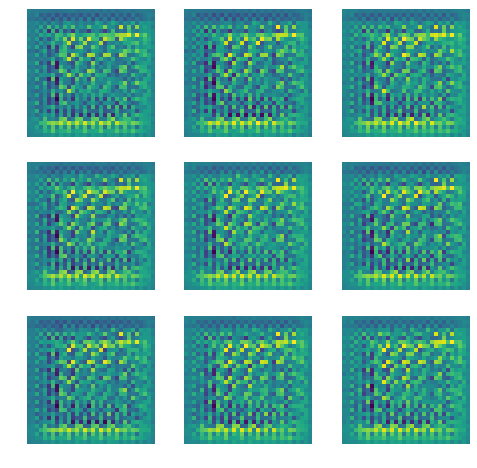

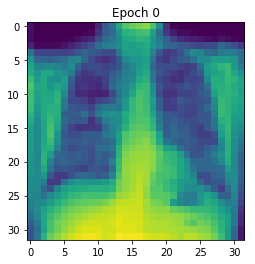

Epoch:0 AUC:0.69


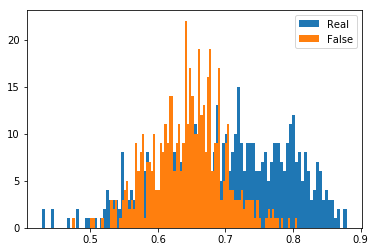

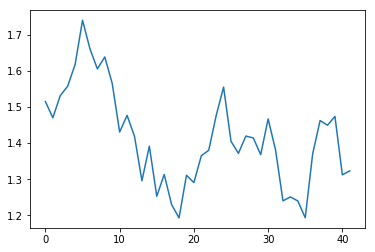

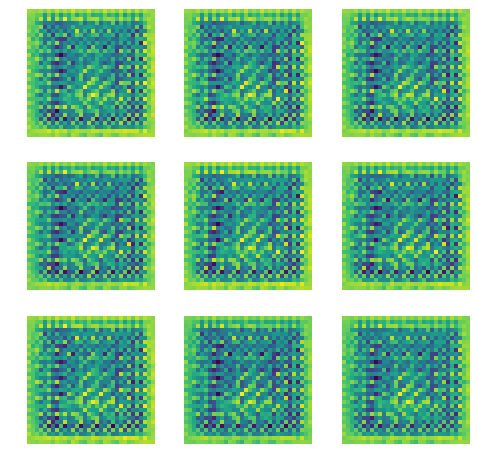

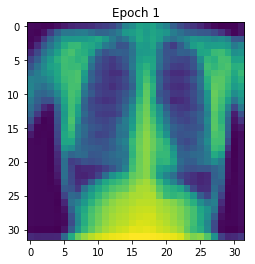

Epoch:1 AUC:0.87


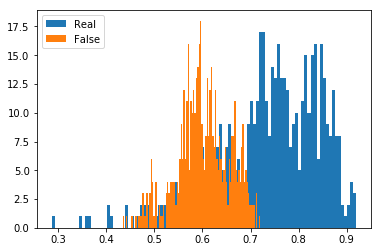

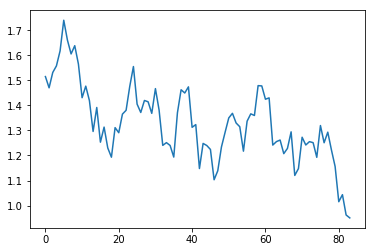

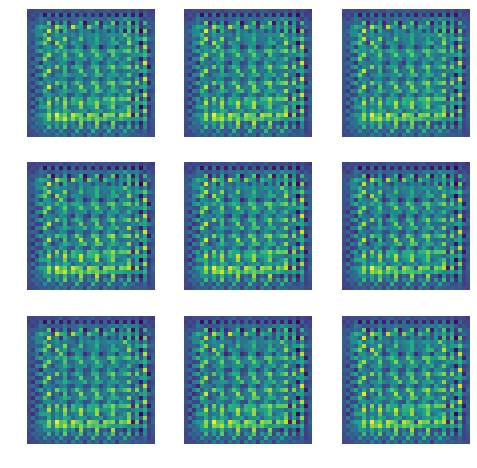

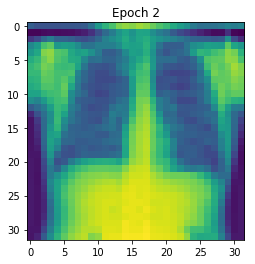

Epoch:2 AUC:0.93


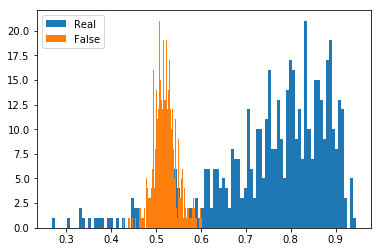

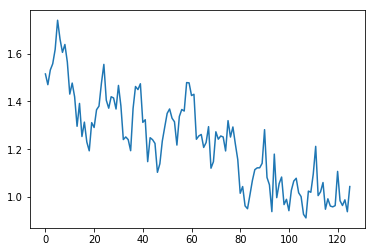

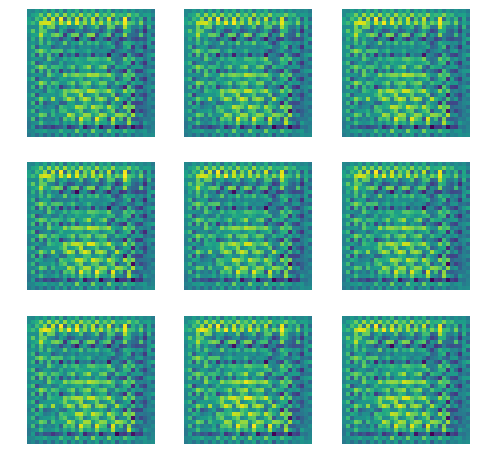

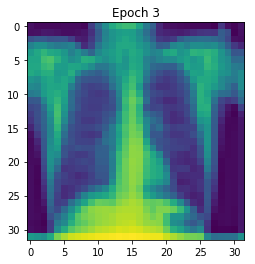

Epoch:3 AUC:0.96


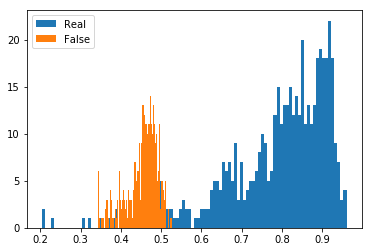

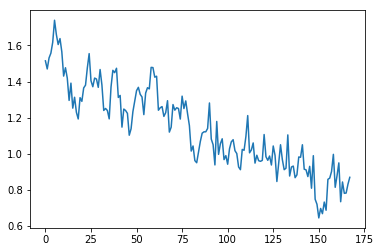

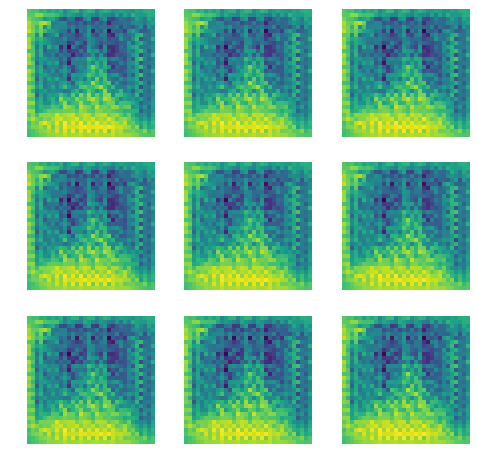

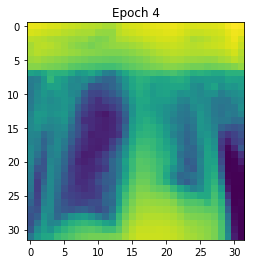

Epoch:4 AUC:0.96


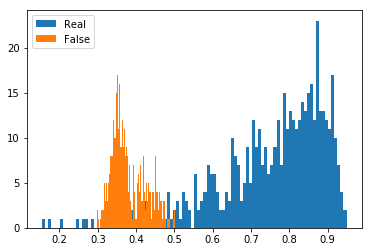

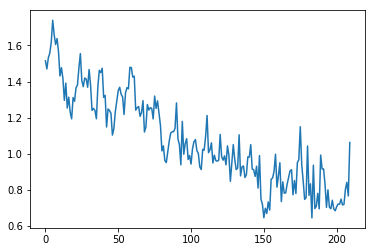

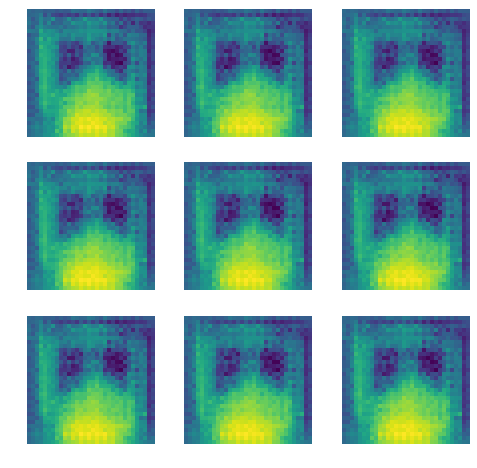

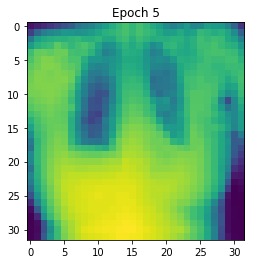

Epoch:5 AUC:0.51


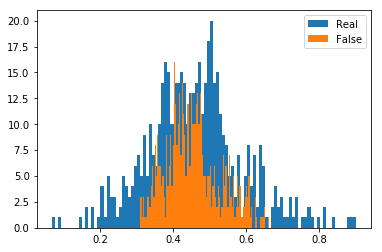

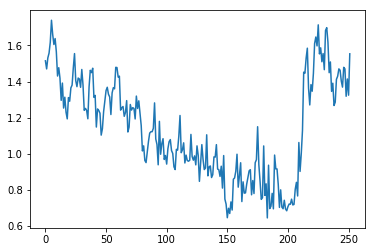

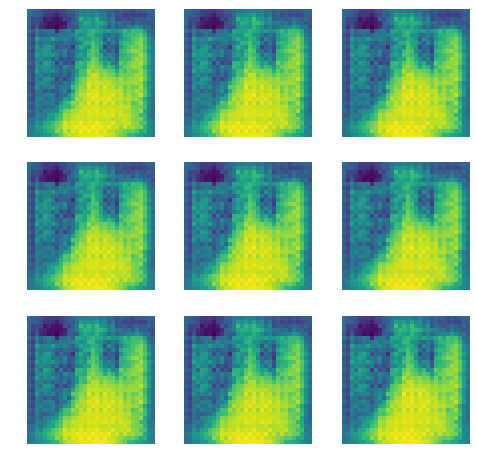

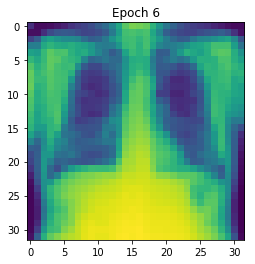

Epoch:6 AUC:0.62


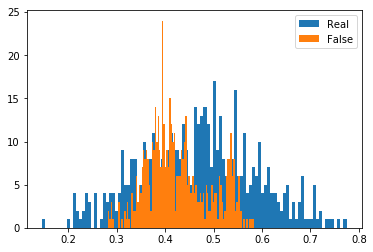

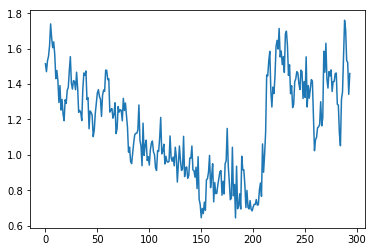

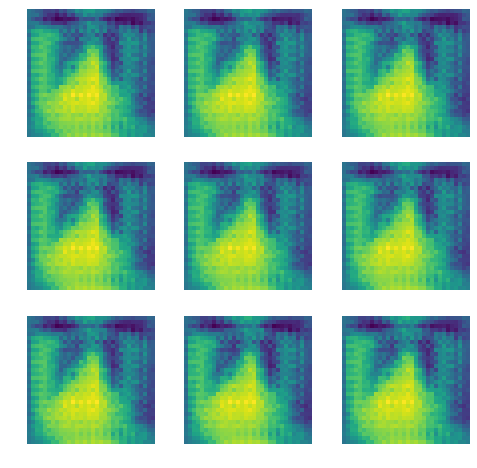

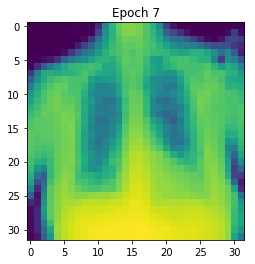

Epoch:7 AUC:0.81


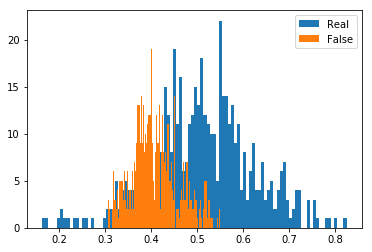

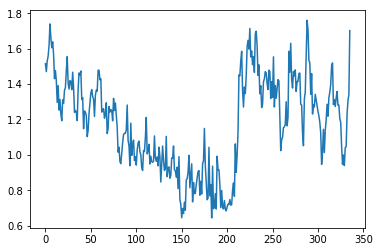

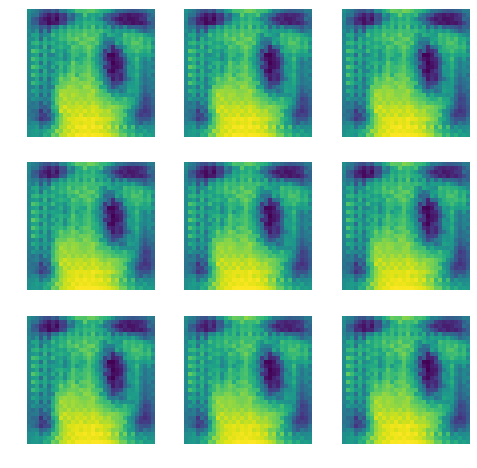

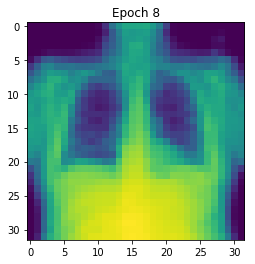

Epoch:8 AUC:0.72


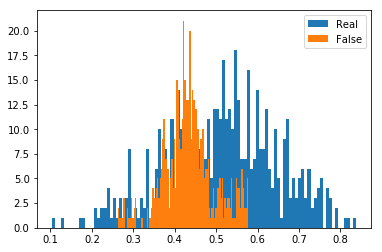

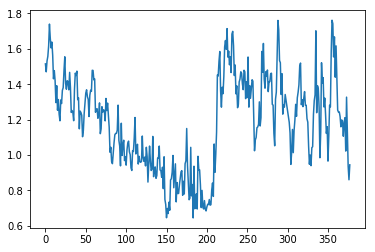

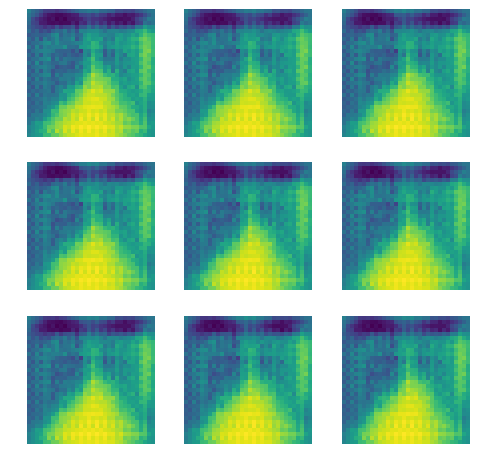

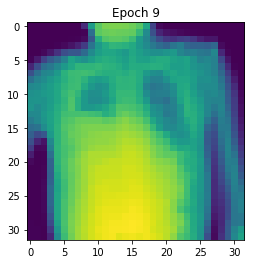

Epoch:9 AUC:0.73


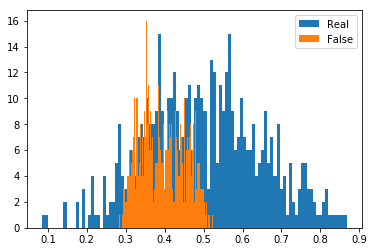

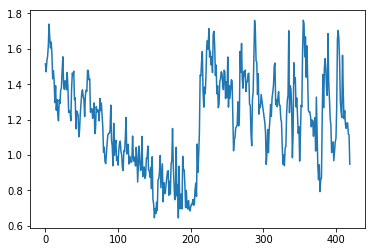

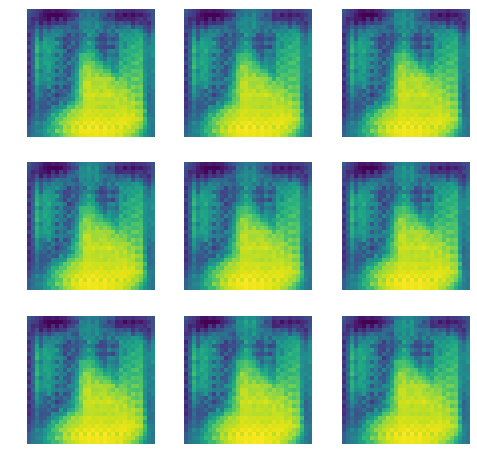

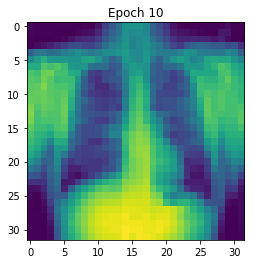

Epoch:10 AUC:0.84


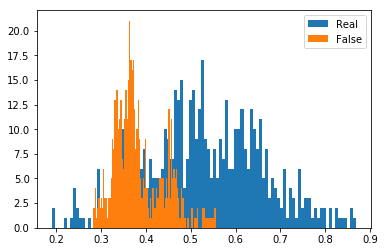

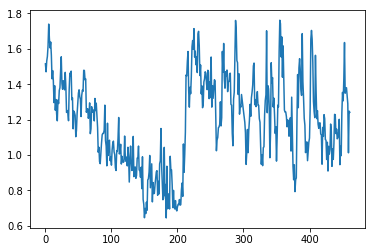

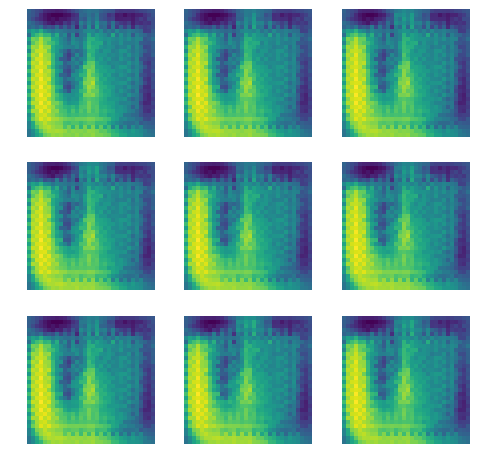

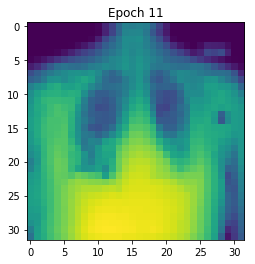

Epoch:11 AUC:0.88


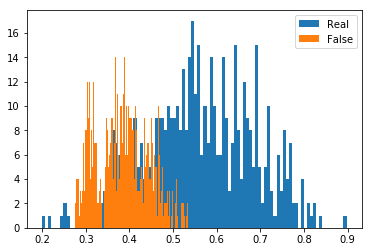

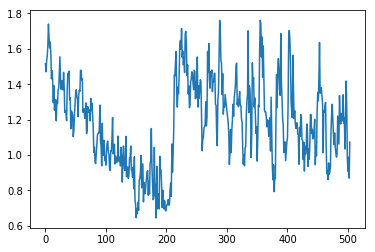

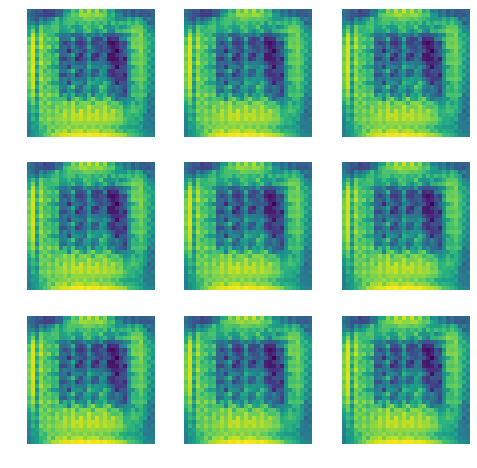

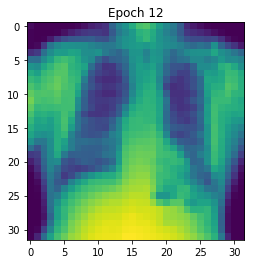

Epoch:12 AUC:0.99


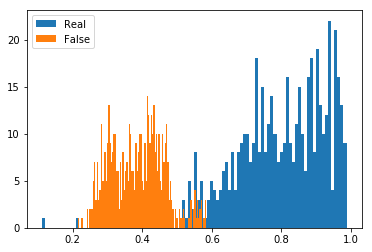

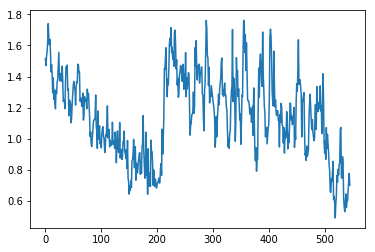

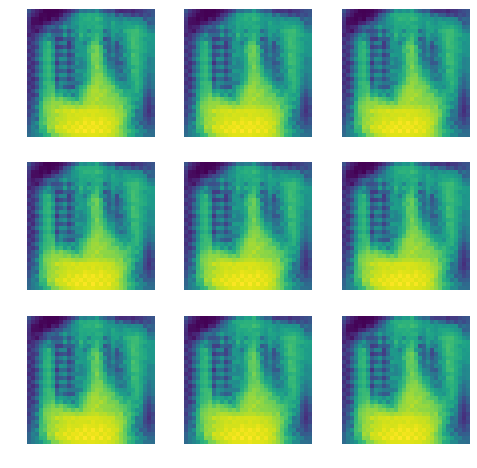

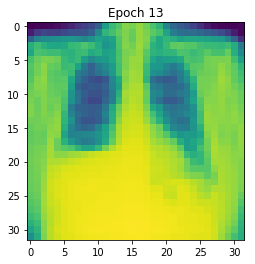

Epoch:13 AUC:0.90


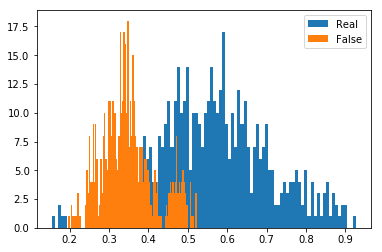

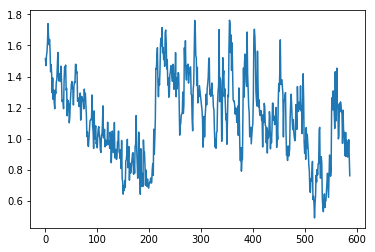

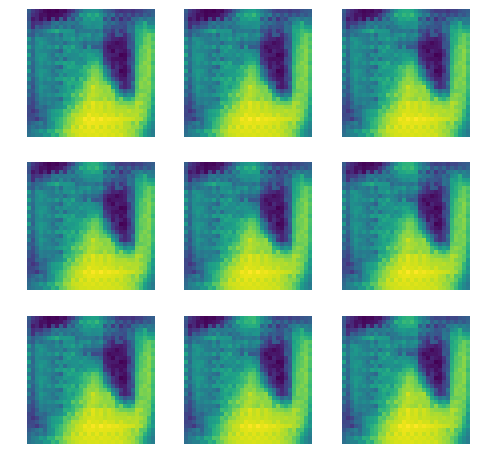

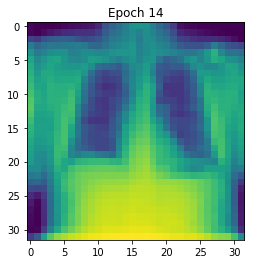

Epoch:14 AUC:0.90


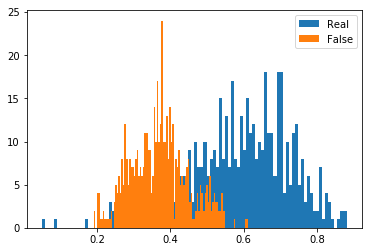

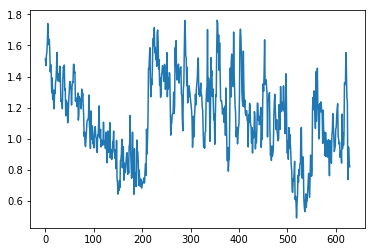

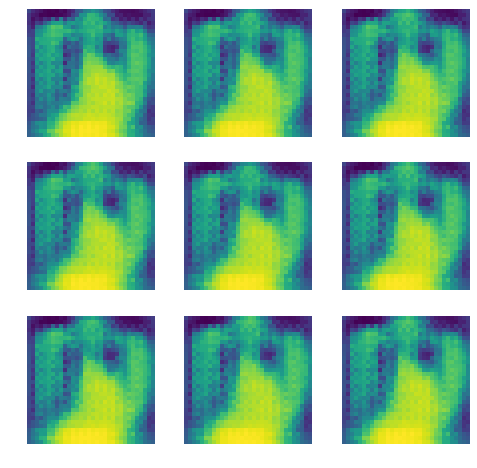

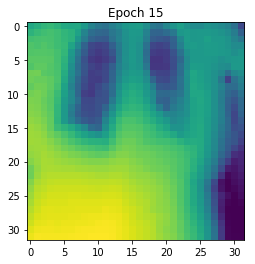

Epoch:15 AUC:0.90


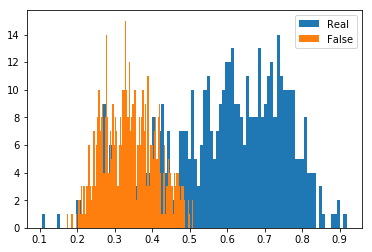

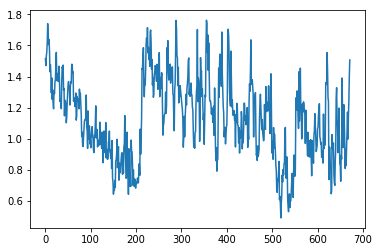

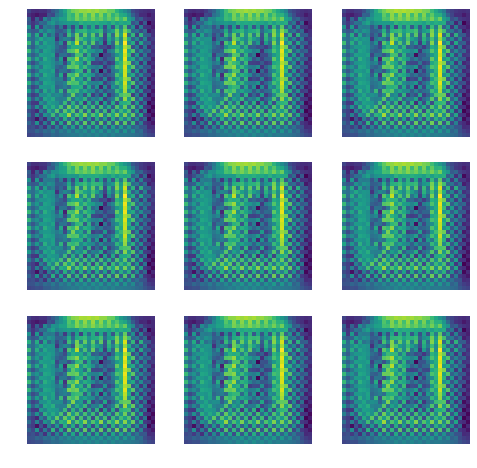

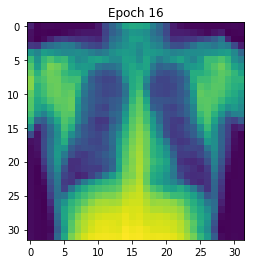

Epoch:16 AUC:0.95


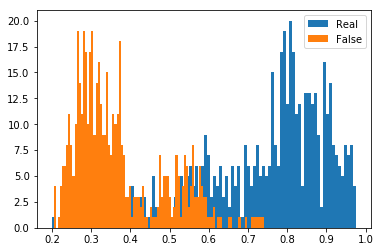

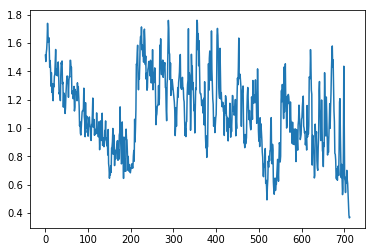

In [ ]:
from torch.autograd import Variable


ConstantZ = torch.randn(9,LS,1,1)

cpt = 0

criterion = nn.BCELoss()
for epoch in range(20):
    
    #Store Discriminator data
    AllRealDisc = []
    AllFakeDisc = []
    
    for dataiter in dataloader:
        
        #Get Data
        data = dataiter
        data_norm = data*2.0-1.0
        #To cuda
        if torch.cuda.is_available():
            data = data.cuda()
        
        #Get Batch Size
        BS = data.shape[0]
        
        #Generate Fake data from random Latent
        FakeData = GenX(torch.randn(BS,LS,1,1))
        
        #Have discriminator do is thing on real and fake data
        PredReal  = DisX(data_norm)
        PredFalse = DisX(FakeData)
        
        #Get loss for discriminator
        loss_d = criterion(PredReal.view(-1), Variable(torch.ones(BS))) + criterion(PredFalse.view(-1), Variable(torch.zeros(BS)))

        #Get loss for generator
        loss_g = criterion(PredFalse.view(-1), Variable(torch.ones(BS))) + criterion(PredReal.view(-1), Variable(torch.zeros(BS)))

        #Optimize Discriminator
        optimizerD.zero_grad()
        loss_d.backward(retain_graph=True)
        optimizerD.step()
    
        #Optimize Generator
        optimizerG.zero_grad()
        loss_g.backward()
        optimizerG.step()
    
    
        #StoreInfo
        DiscriminatorLoss.append(loss_d.detach().numpy()+0)
        AllRealDisc += list(np.ravel(PredReal.detach().numpy()))
        AllFakeDisc += list(np.ravel(PredFalse.detach().numpy()))
        
        
        #break
        
    auc = roc_auc_score([1]*len(AllRealDisc)+[0]*len(AllFakeDisc),AllRealDisc+AllFakeDisc)    
    AllAUC.append(auc)
        #break
    if epoch % 1 == 0:
        with torch.no_grad():
            FakeData = GenX(ConstantZ).detach().numpy()
            plt.figure(figsize=(8,8))

            c = 0
            for fd in FakeData:
                c +=1
                #print(fd.shape)
                plt.subplot(3,3,c)
                plt.imshow(fd[0])
                plt.axis("off")
            plt.show()
            
            plt.imshow(data[0][0])
            plt.title("Epoch %d" % (epoch))
            plt.show()


            print("Epoch:%d AUC:%.2f" % (epoch,auc))


            plt.hist(AllRealDisc,100,label="Real")
            plt.hist(AllFakeDisc,100,label="False")
            plt.legend()
            plt.show()


            plt.plot(range(len(DiscriminatorLoss)),DiscriminatorLoss)
            plt.show()

    #break

In [ ]:
FakeData.shape

In [ ]:
FakeData = GenX(ConstantZ).detach().numpy()
plt.figure(figsize=(8,8))

c = 0
for fd in FakeData:
    c +=1
    #print(fd.shape)
    plt.subplot(3,3,c)
    plt.imshow(fd[0])
    plt.axis("off")
plt.show()

In [ ]:
plt.imshow(data[0][0])

In [ ]:
np.min(GenX(ConstantZ).detach().numpy()[0][0])